## **ECG Arrhythmia Classification** 

---



---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
pip install minisom

  Created wheel for minisom: filename=MiniSom-2.2.5-cp36-none-any.whl size=8474 sha256=80a16690e5e19ef0dbc45f0841dd512f57d313ee2b04a4131c6f0da57ccb8fcd
  Stored in directory: /root/.cache/pip/wheels/39/5b/16/cc9402ffc58cafb1da6997e5c94b1bde65e8cb214907879fd4
Successfully built minisom


In [0]:
pip install SimpSOM

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 

import sys
sys.path.insert(0, '../')

from minisom import MiniSom
from matplotlib.gridspec import GridSpec


In [0]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/mitbih_train.csv', header=None)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/mitbih_test.csv', header=None)

In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **EDA**

---



In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


We need to make sure there are no missing values, from the function info we already know. 

In [9]:
df_train.isnull().count()

0      87554
1      87554
2      87554
3      87554
4      87554
       ...  
183    87554
184    87554
185    87554
186    87554
187    87554
Length: 188, dtype: int64

In [10]:
df_train.iloc[:,-1].unique()

array([0., 1., 2., 3., 4.])

We have 5 different classes, each one belong to a different case of arrhythmia: 
- 0 --> N (normal)
- 1 --> S (supraventicular ectopic beat)
- 2 --> V (ventricular ectopic beat)
- 3 --> F (fusion beat)
- 4 --> Q (not QRS-unknown)

In [11]:
df_train.iloc[:,-1].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

As we can see, the classes are not balance, considering the difference between the highest and the lowest. We can proceed with different ways: 
- we can do sampling of the other, and do some data augmentation on class 3 (Fusion)
- we can concatenate the two datasets and try to divide it equally and add an additional set for validation to obtain better results

In [12]:

print(72471/87554)
print(6431/87554)
print(5788/87554)
print(2223/87554)
print(641/87554)

0.8277291728533248
0.07345181259565525
0.06610777348836147
0.025390045000799506
0.007321196061858967


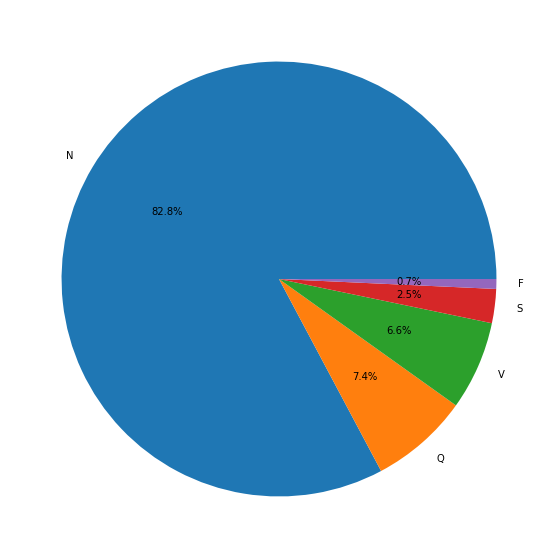

In [13]:
plt.figure(figsize=(20,10))
plt.pie([82.77,7.35,6.61,2.53,0.73], labels=['N', 'Q', 'V', 'S','F'],autopct='%1.1f%%')
plt.show()

For the test dataset, we expect to have the same relation as the training set, we can visualize it using another type of graph. 

In [14]:
df_test.iloc[:,-1].value_counts()

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [16]:
print(18118/21891)
print(1608/21891)
print(1448/21891)
print(556/21891)
print(162/21891)

0.827646064592755
0.073454844456626
0.06614590470969806
0.025398565620574666
0.007400301493764561


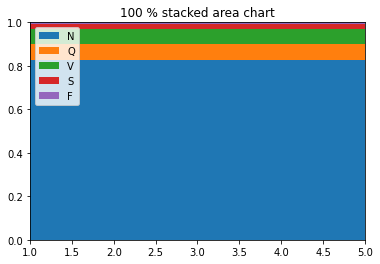

In [17]:
# Make data
data = pd.DataFrame({  'N':[82.76], 'Q':[7.35], 'V':[6.61],'S':[2.54],'F':[0.74] }, index=range(1,6))
 
# We need to transform the data from raw data to percentage (fraction)
data_perc = data.divide(data.sum(axis=1), axis=0)
 
# Make the plot
plt.stackplot(range(1,6),  data_perc['N'],  data_perc['Q'],  data_perc['V'],data_perc['S'], data_perc['F'], labels=['N','Q','V','S','F'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('100 % stacked area chart')
plt.show()


We obtain practically the same percentage frequency of each class as in the training, as it has been divided with that intention to obtain better results. We will not try to balance the test set for now. 

# **Splitting into training, testing and validation**

We are going to concatenate the two datasets and try to divide it into 3 different sets, training, testing and validation, considering a balance set of classes in each set

In [18]:
df_final = pd.concat([df_train, df_test])
labels = df_final.iloc[:,-1]
print(labels)
#y = to_categorical(labels)
#print(y)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21887    4.0
21888    4.0
21889    4.0
21890    4.0
21891    4.0
Name: 187, Length: 109446, dtype: float64


We will split our final dataset into 3 sets, we will be using the stratified shuffle, as the function tries to balance the division according to the frequency of each class in the final set. 

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
for train_index, test_valid_index in split.split(df_final, labels):
    train_set = df_final.iloc[train_index]
    test_valid_set = df_final.iloc[test_valid_index]


split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test_index, valid_index in split2.split(test_valid_set, test_valid_set.iloc[:,-1]):
    test_set = test_valid_set.iloc[test_index]
    valid_set = test_valid_set.iloc[valid_index]

In [21]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65667 entries, 21167 to 13042
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 94.7 MB


In [22]:
train_set.iloc[:,-1].value_counts()

0.0    54353
4.0     4823
2.0     4342
1.0     1667
3.0      482
Name: 187, dtype: int64

In [23]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35023 entries, 20171 to 55165
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 50.5 MB


In [24]:
test_set.iloc[:,-1].value_counts()

0.0    28989
4.0     2573
2.0     2315
1.0      889
3.0      257
Name: 187, dtype: int64

In [25]:
valid_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8756 entries, 15289 to 43543
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 12.6 MB


In [26]:
valid_set.iloc[:,-1].value_counts()

0.0    7247
4.0     643
2.0     579
1.0     223
3.0      64
Name: 187, dtype: int64

As we can see, we have not been able to reach a balance training_set, as it is clear that are more of class N than of any other. So we will now do resampling to have the same value of each class in the training set. 

In [0]:
df_S=train_set[train_set[187]==1]
df_V=train_set[train_set[187]==2]
df_F=train_set[train_set[187]==3]
df_Q=train_set[train_set[187]==4]
df_N=(train_set[train_set[187]==0]).sample(n=30000,random_state=42)

In [0]:
df_S_add=resample(df_S,replace=True,n_samples=30000,random_state=123)
df_V_add=resample(df_V,replace=True,n_samples=30000,random_state=124)
df_F_add=resample(df_F,replace=True,n_samples=30000,random_state=125)
df_Q_add=resample(df_Q,replace=True,n_samples=30000,random_state=126)

train_set_balance=pd.concat([df_N,df_S_add,df_V_add,df_F_add,df_Q_add])

In [84]:
train_set_balance.iloc[:,-1].value_counts()

1.0    30000
4.0    30000
3.0    30000
2.0    30000
0.0    30000
Name: 187, dtype: int64

In [29]:
type(train_set_balance)

pandas.core.frame.DataFrame

Now that we have our training set with the same frequency per class, we are going to visualize how each class is represented graphically as an ECG. 


We are going to get 5 random sample to plot, and represent the heartbeat signal. 

In [85]:
c=train_set_balance.groupby(train_set_balance.iloc[:,-1],group_keys=False)

df_samples = pd.DataFrame(data=None)

for group_name, df_group in c:
  print(group_name)
  #print(type(df_group))
  d=df_group.sample(1)
  #print(type(d))
  #print(d)
  df_samples = df_samples.append(d)


0.0
1.0
2.0
3.0
4.0


In [86]:
df_samples.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
1517,1.000000,0.580897,0.171540,0.187135,0.134503,0.027290,0.013645,0.046784,0.142300,0.239766,0.278752,0.286550,0.296296,0.317739,0.329435,0.319688,0.309942,0.327485,0.341131,0.339181,0.335283,0.331384,0.341131,0.362573,0.364522,0.360624,0.366472,0.370370,0.389864,0.397661,0.409357,0.409357,0.424951,0.442495,0.452242,0.458090,0.467836,0.493177,0.506823,0.506823,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73630,1.000000,0.896959,0.380068,0.111486,0.052365,0.015203,0.018581,0.045608,0.108108,0.266892,0.395270,0.435811,0.435811,0.440878,0.439189,0.444257,0.435811,0.422297,0.415541,0.408784,0.393581,0.375000,0.363176,0.364865,0.342905,0.339527,0.331081,0.334459,0.347973,0.349662,0.364865,0.390203,0.417230,0.430743,0.451014,0.467905,0.469595,0.464527,0.472973,0.478041,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18711,0.000000,0.046683,0.149877,0.208845,0.262899,0.257985,0.316953,0.422604,0.457002,0.457002,0.457002,0.464373,0.481572,0.486486,0.513514,0.515971,0.550369,0.555283,0.587224,0.601966,0.628993,0.638821,0.660934,0.660934,0.670762,0.663391,0.663391,0.633907,0.619165,0.587224,0.579853,0.533170,0.533170,0.506142,0.493858,0.471744,0.474201,0.461916,0.459459,0.449631,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
80884,0.237548,0.011494,0.000000,0.218391,0.386973,0.551724,0.674330,0.773946,0.804598,0.808429,0.823755,0.842912,0.842912,0.835249,0.846743,0.854406,0.858238,0.865900,0.862069,0.862069,0.877395,0.885057,0.888889,0.888889,0.892720,0.904215,0.927203,0.927203,0.938697,0.965517,0.969349,0.980843,0.996169,0.977012,1.000000,0.980843,0.969349,0.973180,0.969349,0.954023,...,0.915709,0.91954,0.923372,0.923372,0.927203,0.934866,0.94636,0.954023,0.957854,0.954023,0.965517,0.977012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
83783,0.926521,0.881745,0.818599,0.764638,0.681975,0.586682,0.479908,0.363949,0.247991,0.188289,0.142365,0.089552,0.034443,0.000000,0.067738,0.188289,0.272101,0.315729,0.350172,0.373134,0.416762,0.481056,0.539610,0.611940,0.672790,0.721010,0.718714,0.735936,0.745121,0.749713,0.745121,0.752009,0.747417,0.757750,0.764638,0.780712,0.792193,0.811711,0.822044,0.830080,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


**CLASS NORMAL**

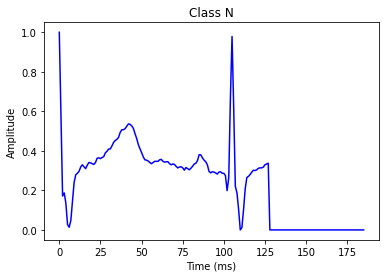

In [87]:
plt.plot(df_samples.iloc[0,:186], 'b')
plt.title('Class N')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.show()

**CLASS Supraventicular ectopic beat**

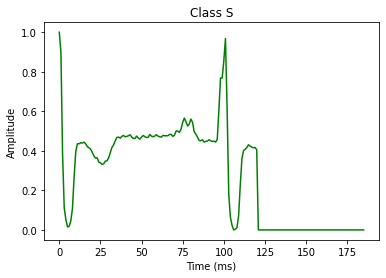

In [88]:
plt.plot(df_samples.iloc[1,:186], 'g')
plt.title('Class S')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.show()

**CLASS Ventricular ectopic beat**

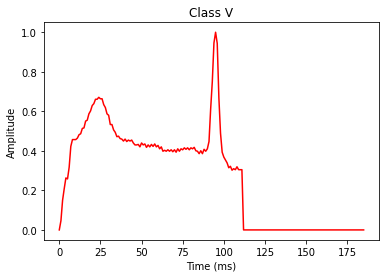

In [89]:
plt.plot(df_samples.iloc[2,:186], 'r')
plt.title('Class V')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.show()

**CLASS FUSION**

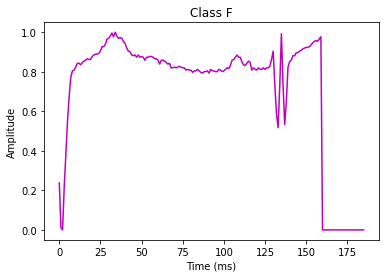

In [90]:
plt.plot(df_samples.iloc[3,:186], 'm')
plt.title('Class F')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.show()

**CLASS not QRS-unknown**

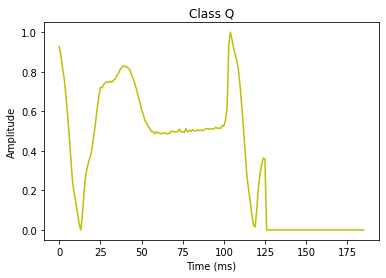

In [91]:
plt.plot(df_samples.iloc[4,:186], 'y')
plt.title('Class Q')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.show()

Now lets combine them all in one graph, to see how they overlap. 

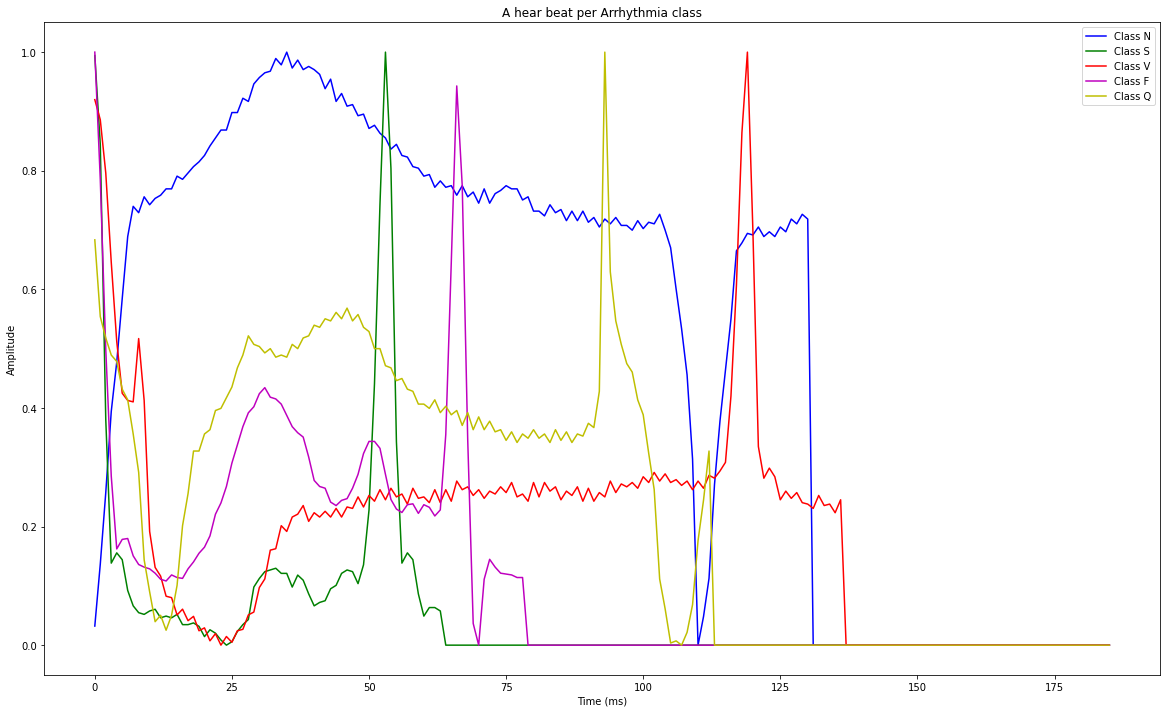

In [37]:
plt.figure(figsize=(20,12))
plt.plot( df_samples.iloc[0,:186], 'b', label='Class N')
plt.plot( df_samples.iloc[1,:186], 'g', label='Class S')
plt.plot( df_samples.iloc[2,:186], 'r', label='Class V')
plt.plot( df_samples.iloc[3,:186], 'm', label='Class F')
plt.plot( df_samples.iloc[4,:186], 'y', label='Class Q')
plt.legend()
plt.title('A hear beat per Arrhythmia class')
plt.ylabel('Amplitude')
plt.xlabel('Time (ms)')
plt.show()

We can see that each class has a different signal representation, so now, we are going to procceed with the model training. 

## **TRAINING MODELS**

---






We are going to start with a simple neural network, to see how is the performance, and if it is not good enough we can optimize our model. 

**CNN**

In [0]:
y_train = train_set_balance.iloc[:,-1]


In [0]:
train_set_balance.reset_index(drop=True, inplace=True)

In [0]:
del train_set_balance[187]

In [41]:
train_set_balance.shape

(150000, 187)

In [0]:
y_train_cat = to_categorical(y_train)

In [0]:
y_test=test_set.iloc[:,-1]
del test_set[187]
y_test = to_categorical(y_test)

In [0]:
y_valid=valid_set.iloc[:,-1]
del valid_set[187]
y_valid = to_categorical(y_valid)

In [59]:
model = Sequential()
model.add(Dense(60, activation='relu', input_shape=(187,)))
model.add(Dense(60, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_train = model.fit(train_set_balance, y_train_cat, epochs=20)

model.summary()
print("Evaluation: ")
mse, acc = model.evaluate(test_set, y_test)
print('mean_squared_error :', mse)
print('accuracy:', acc)

Epoch 1/20
150000/150000 [==============================] - 8s 51us/step - loss: 0.4003 - accuracy: 0.8560
Epoch 2/20
150000/150000 [==============================] - 7s 50us/step - loss: 0.2196 - accuracy: 0.9227
Epoch 3/20
150000/150000 [==============================] - 8s 50us/step - loss: 0.1650 - accuracy: 0.9444
Epoch 4/20
150000/150000 [==============================] - 8s 51us/step - loss: 0.1321 - accuracy: 0.9557
Epoch 5/20
150000/150000 [==============================] - 8s 55us/step - loss: 0.1102 - accuracy: 0.9636
Epoch 6/20
150000/150000 [==============================] - 9s 60us/step - loss: 0.0956 - accuracy: 0.9678
Epoch 7/20
150000/150000 [==============================] - 8s 54us/step - loss: 0.0847 - accuracy: 0.9724
Epoch 8/20
150000/150000 [==============================] - 8s 54us/step - loss: 0.0755 - accuracy: 0.9753
Epoch 9/20
150000/150000 [==============================] - 8s 55us/step - loss: 0.0699 - accuracy: 0.9772
Epoch 10/20
150000/150000 [==========

For the training test we obtain a pretty high accuray of about 0.96, considering that our NN is quite simple. 

Finally we are going to see how it behaves with the testing test. 

In [0]:
y_pred_val = model.predict(valid_set, batch_size=1000)

In [61]:
print(classification_report(y_valid.argmax(axis=1), y_pred_val.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98      7247
           1       0.59      0.82      0.69       223
           2       0.86      0.94      0.90       579
           3       0.44      0.78      0.56        64
           4       0.95      0.98      0.96       643

    accuracy                           0.96      8756
   macro avg       0.77      0.89      0.82      8756
weighted avg       0.96      0.96      0.96      8756



We are going to validate our results with the validation test. 

In [0]:
y_pred = model.predict(test_set, batch_size=1000)

In [63]:
y_pred

array([[1.1013302e-05, 5.8165091e-11, 1.3945745e-05, 9.9997509e-01,
        9.2770716e-09],
       [1.0000000e+00, 5.2979249e-10, 9.5985130e-15, 2.5286469e-16,
        1.7248549e-08],
       [9.9998391e-01, 1.6148681e-05, 5.1481845e-08, 8.5502740e-18,
        8.5180035e-20],
       ...,
       [1.4567601e-07, 7.4274678e-05, 9.9989080e-01, 1.9556299e-05,
        1.5265099e-05],
       [9.9999487e-01, 1.2791102e-12, 1.3880599e-06, 1.4472372e-11,
        3.6394042e-06],
       [9.9997151e-01, 8.8329379e-08, 2.8428956e-05, 3.7737886e-11,
        1.2244437e-14]], dtype=float32)

In [64]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     28989
           1       0.62      0.82      0.71       889
           2       0.86      0.94      0.90      2315
           3       0.55      0.87      0.68       257
           4       0.96      0.98      0.97      2573

    accuracy                           0.96     35023
   macro avg       0.80      0.91      0.85     35023
weighted avg       0.97      0.96      0.96     35023



In general, we have obtained pretty good accuracy points in all the sets, 0.96 in each case. 

**SELF ORGANIZING MAP**

In [0]:
import SimpSOM as sps

In [0]:
train_set_balance_array =train_set_balance.to_numpy()

Periodic Boundary Conditions active.
The weights will be initialised randomly.
Training SOM... done!


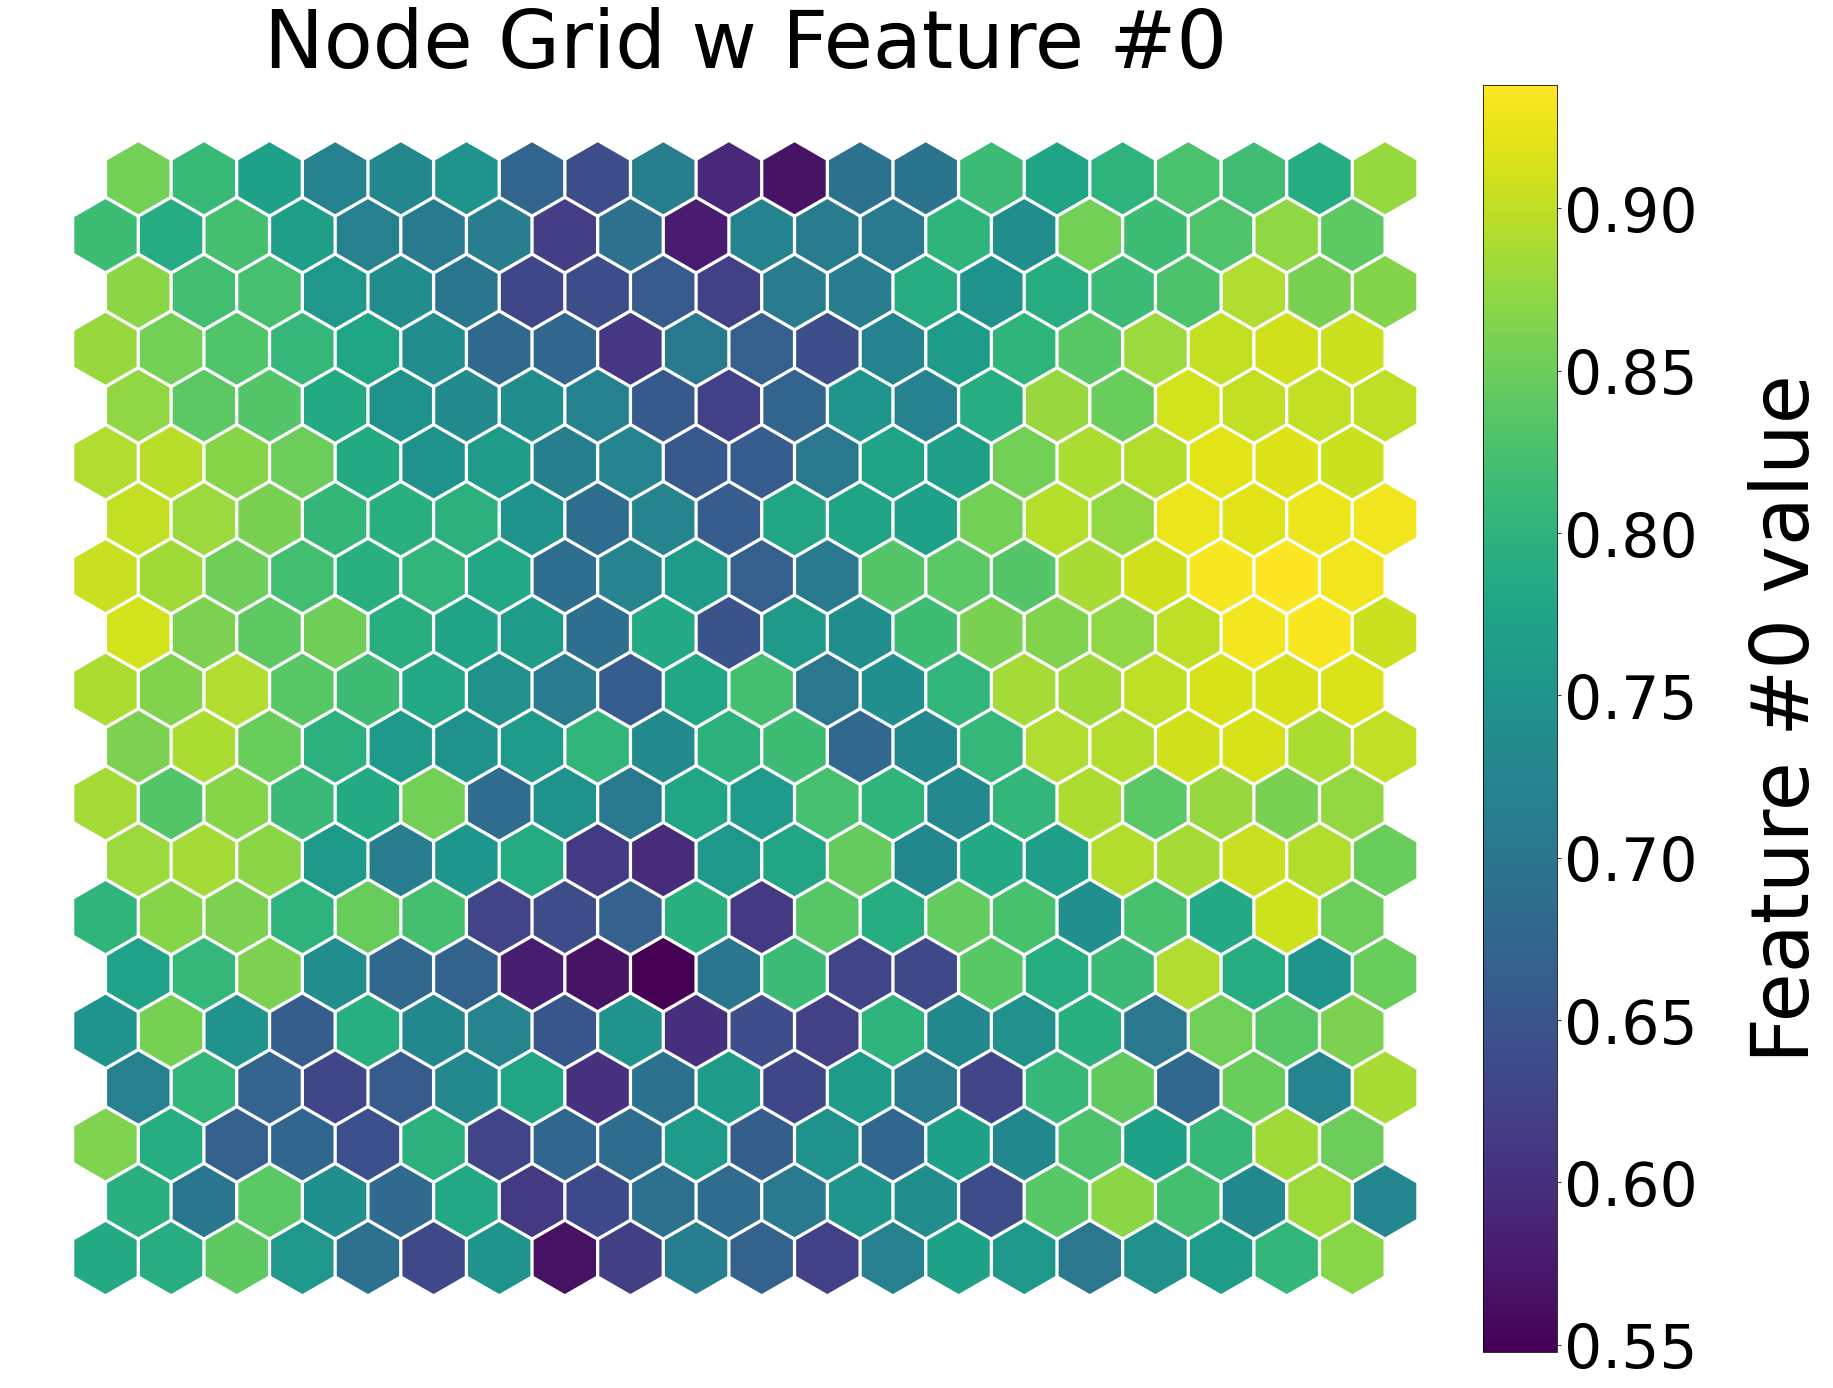

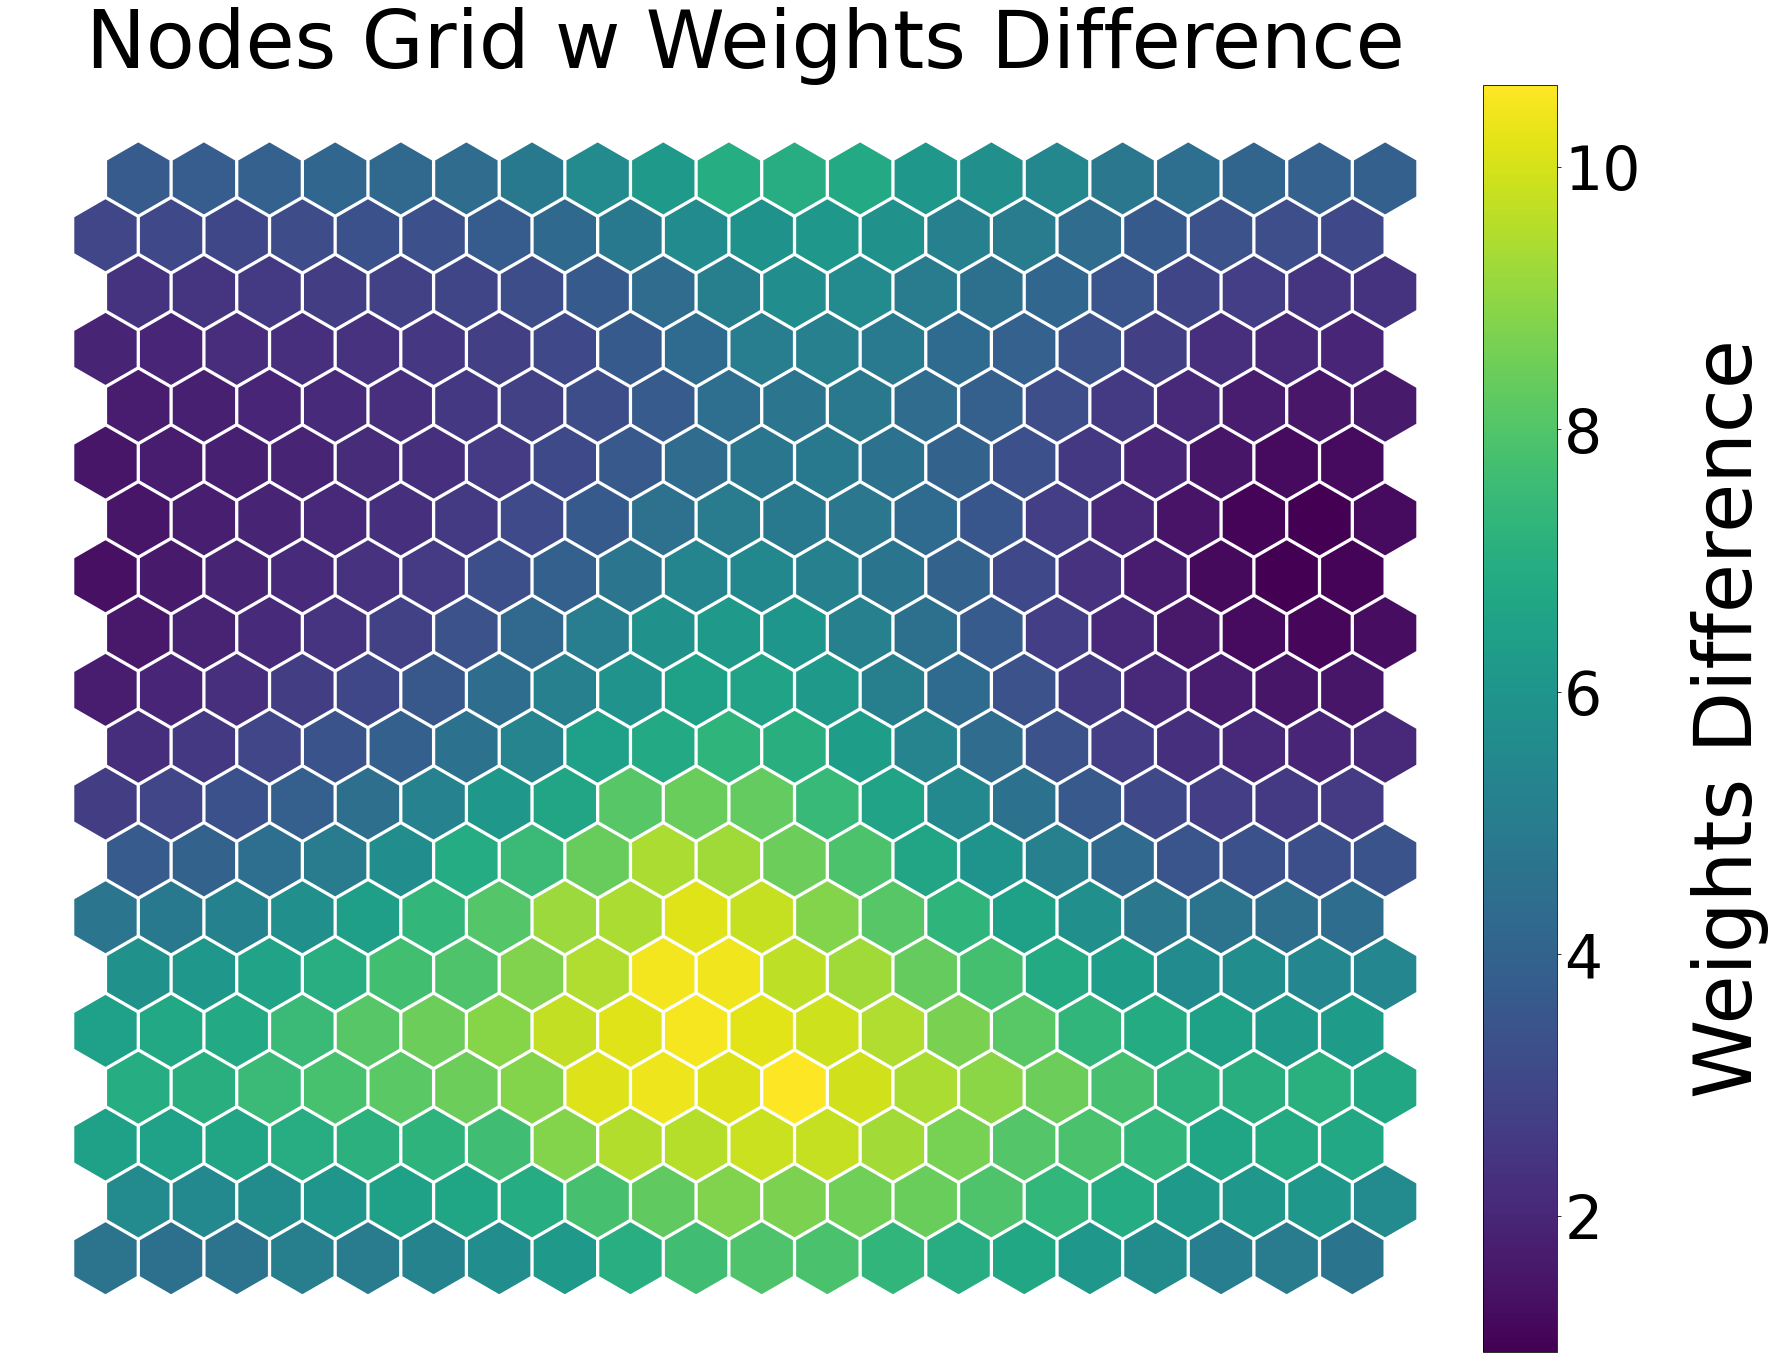

In [70]:
net = sps.somNet(20, 20, train_set_balance_array, PBC=True)
net.train(0.01, 1000)
net.save('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/filename_weights')
net.nodes_graph(colnum=0)
net.diff_graph()

Lets try with this other library the minisom. 

In [105]:
data = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/mitbih_train.csv', delimiter=',', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186))
data = data - np.mean(data, axis=0)

som = MiniSom(60, 60, 188, sigma=3., learning_rate=.7, activation_distance='euclidean', topology='hexagonal',
              neighborhood_function='gaussian', random_seed=10)


som.train_batch(data, 1000, verbose=True)  





 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.0994217674662685


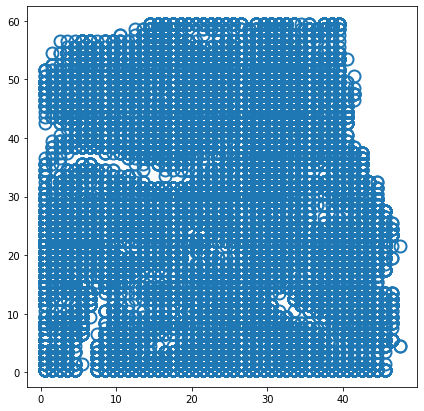

In [106]:

plt.figure(figsize=(7, 7))


target = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/mitbih_train.csv', delimiter=',', usecols=(186), dtype=str)
t = np.zeros(len(target), dtype=int)
t[target == 'N'] = 0
t[target == 'S'] = 1
t[target == 'V'] = 2
t[target == 'F'] = 3
t[target == 'Q'] = 4

markers = ['o', 's', 'D', '*', 'v']
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
for cnt, xx in enumerate(data):
    w = som.winner(xx)  # getting the winner
    # palce a marker on the winning position for the sample xx
    plt.plot(w[0]+.5, w[1]+.5, markers[t[cnt]], markerfacecolor='None',
             markeredgecolor=colors[t[cnt]], markersize=12, markeredgewidth=2)
#plt.axis([0, 7, 0, 7])
plt.savefig('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/som_ECG.png')
plt.show()

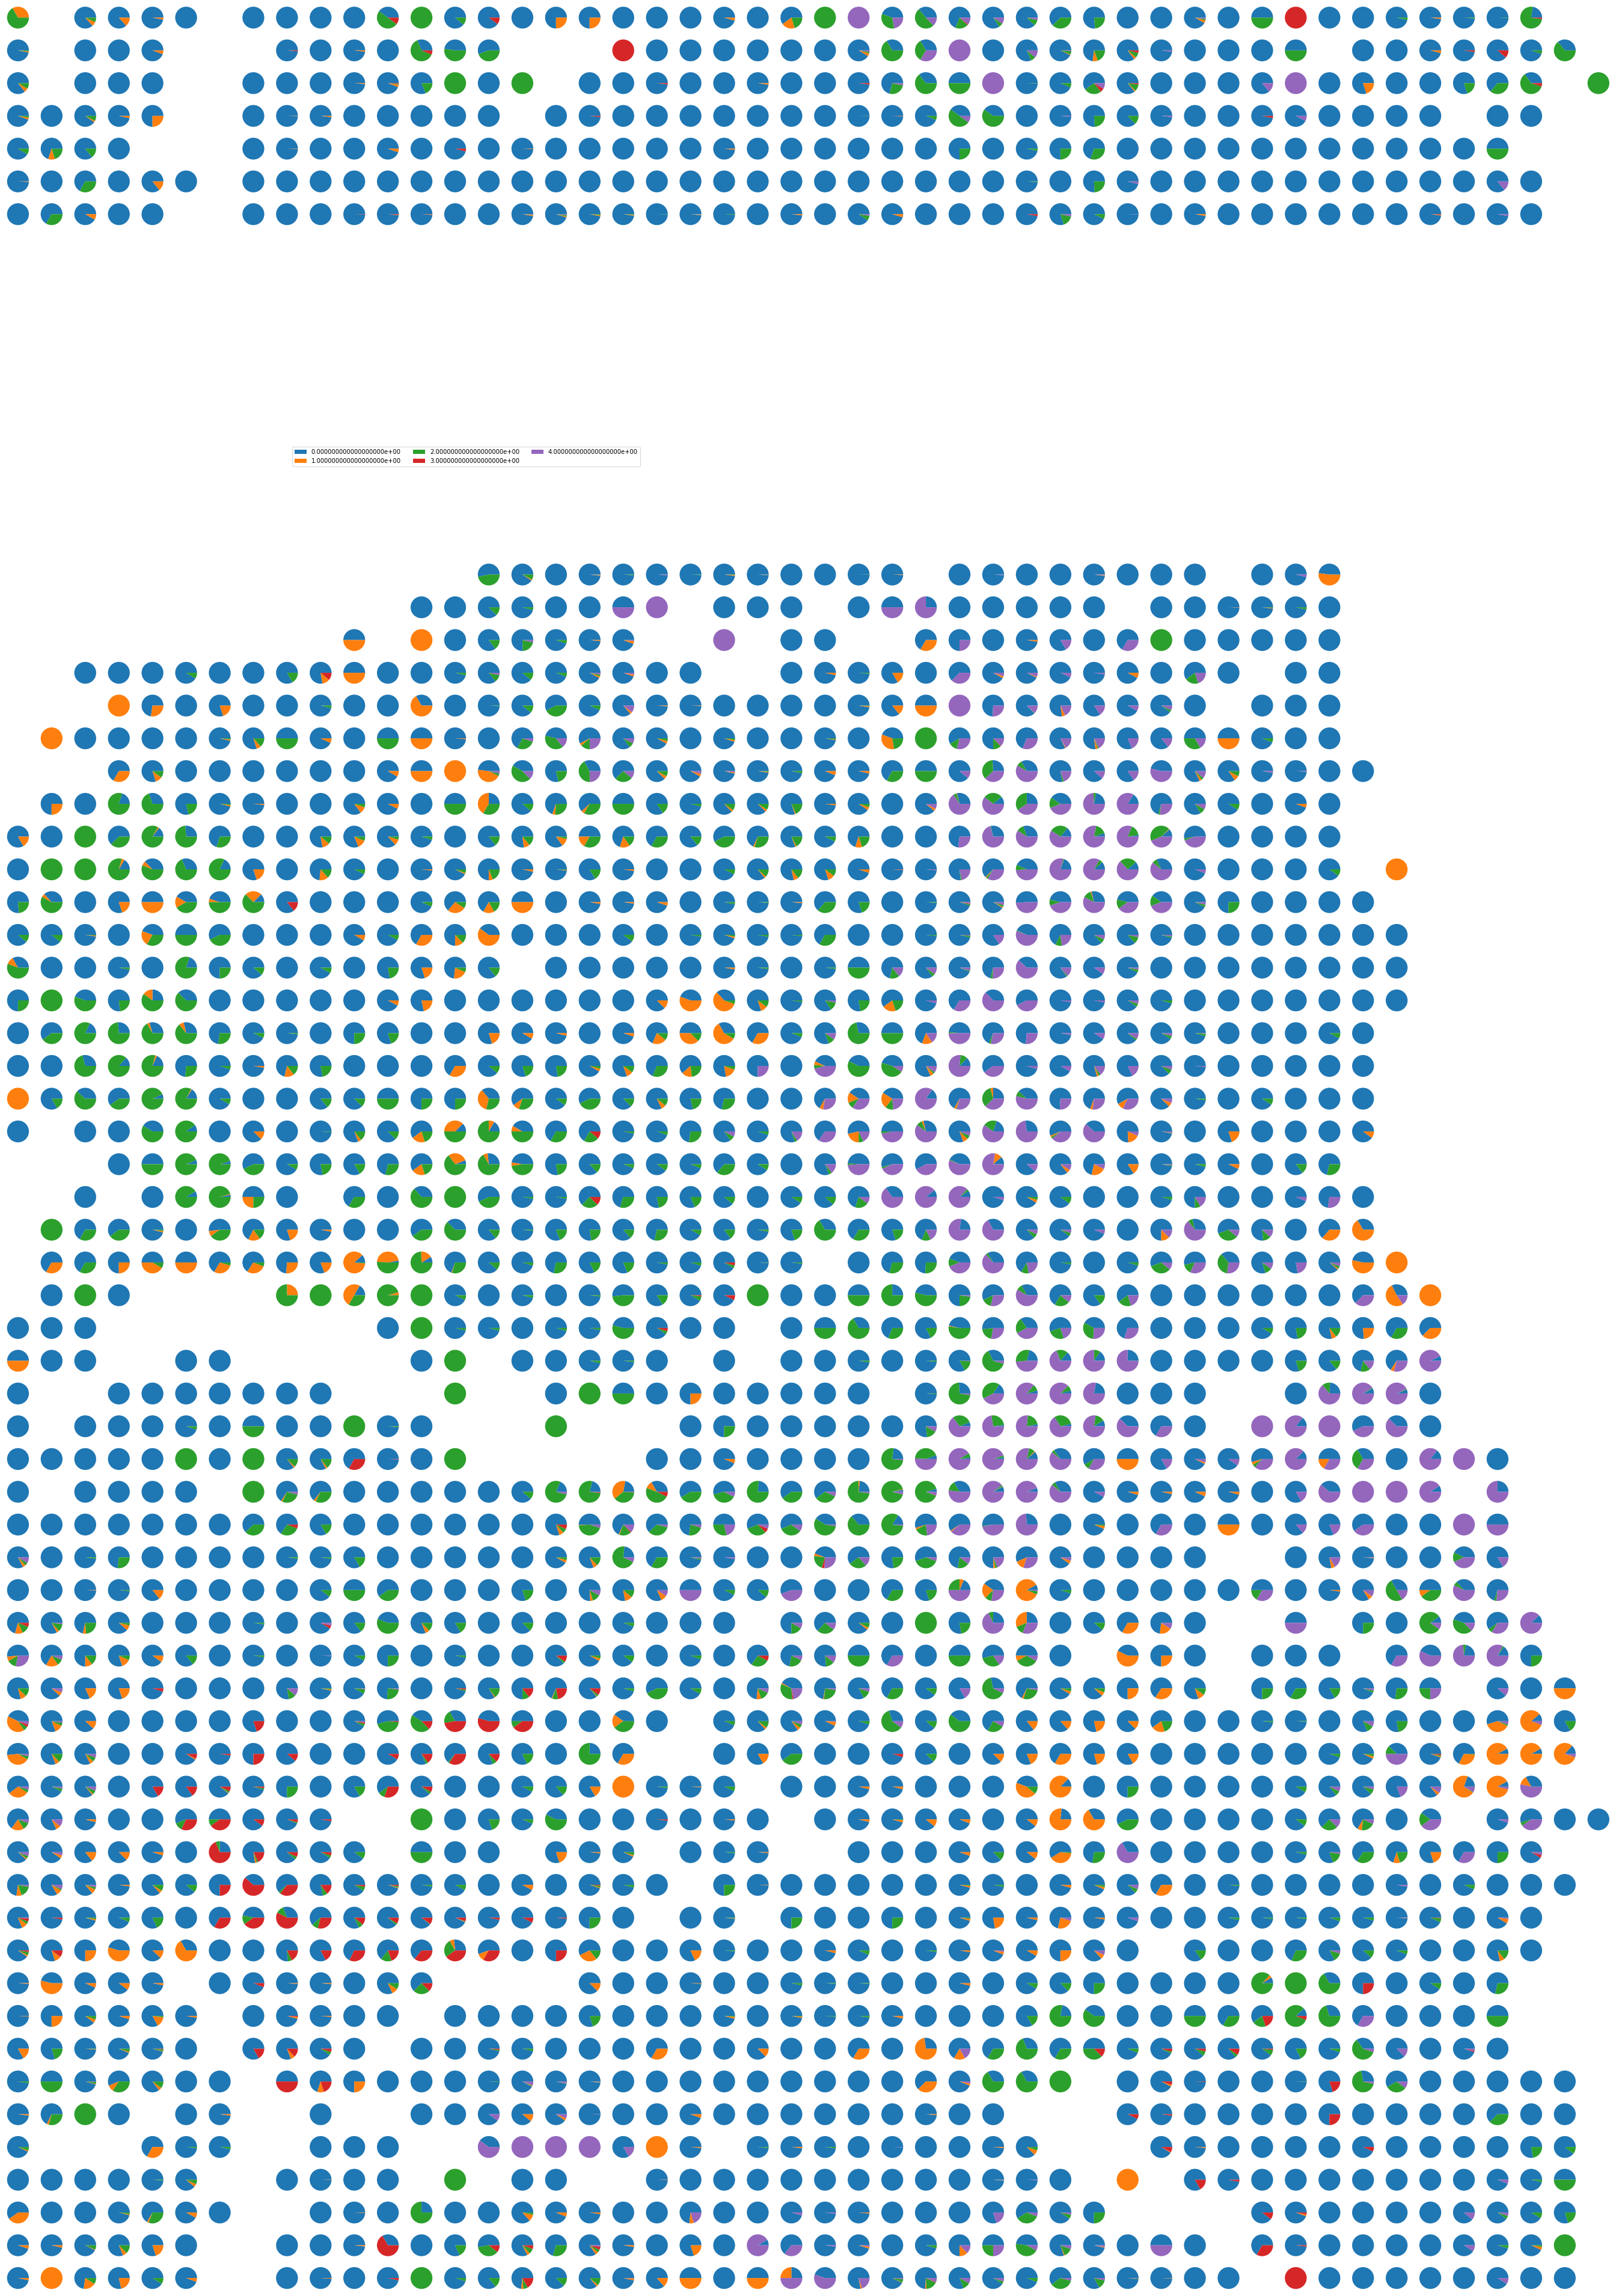

In [107]:


label = np.genfromtxt('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/mitbih_train.csv', delimiter=',', usecols=(187), dtype=str)
labels_map = som.labels_map(data, label)
label_names = np.unique(label)

plt.figure(figsize=(70, 70))
the_grid = GridSpec(70, 70)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0., 6.5), ncol=3)
plt.savefig('/content/drive/My Drive/Colab Notebooks/BIONSPIRED/som_ECG_pies.png')
plt.show()


In [80]:
labels_map

defaultdict(list,
            {(0,
              0): Counter({'0.000000000000000000e+00': 531,
                      '1.000000000000000000e+00': 3,
                      '2.000000000000000000e+00': 64,
                      '3.000000000000000000e+00': 1}),
             (0,
              1): Counter({'0.000000000000000000e+00': 20,
                      '2.000000000000000000e+00': 5,
                      '4.000000000000000000e+00': 2}),
             (0,
              2): Counter({'0.000000000000000000e+00': 139,
                      '1.000000000000000000e+00': 3,
                      '2.000000000000000000e+00': 136,
                      '3.000000000000000000e+00': 1,
                      '4.000000000000000000e+00': 104}),
             (0,
              3): Counter({'0.000000000000000000e+00': 16,
                      '2.000000000000000000e+00': 11,
                      '4.000000000000000000e+00': 184}),
             (0,
              4): Counter({'0.000000000000000000e+00': 61,
 

The results obtained make sense, as here we can see that the classes can easily be mistaken even if we increase the SOM. We can also see that most of them are blue, which is the class 0 corresponding to Normal, the class that had most samples since it is the common one. In some cases classes 2 and 4 can be distinguish, and classes 1 and 3 seem to be the most difficult to classify correctly. 